# Plan

Make to be run from 'final_versions'

Need to fix overlapping orthologous genes. 
- Find overlapping elegans genes and sort into either class 1 or class 2
- See if the orthologs in the other species are also overlapping and in the same class. If not overlapping, no need to do anything. Think about what to do if a different class.
- Use the newly made orths no ops and orths with ops files to do all the stuff from before.
- I'm pretty sure I don't need to do anything with the all_e_genes file. There can be overlaps there, but it doesn't matter because I'm mostly worried about overlaps where it's impossible for synteny breaks to occur but I make it seem like it's possible. So I only need to deal with the orths files.

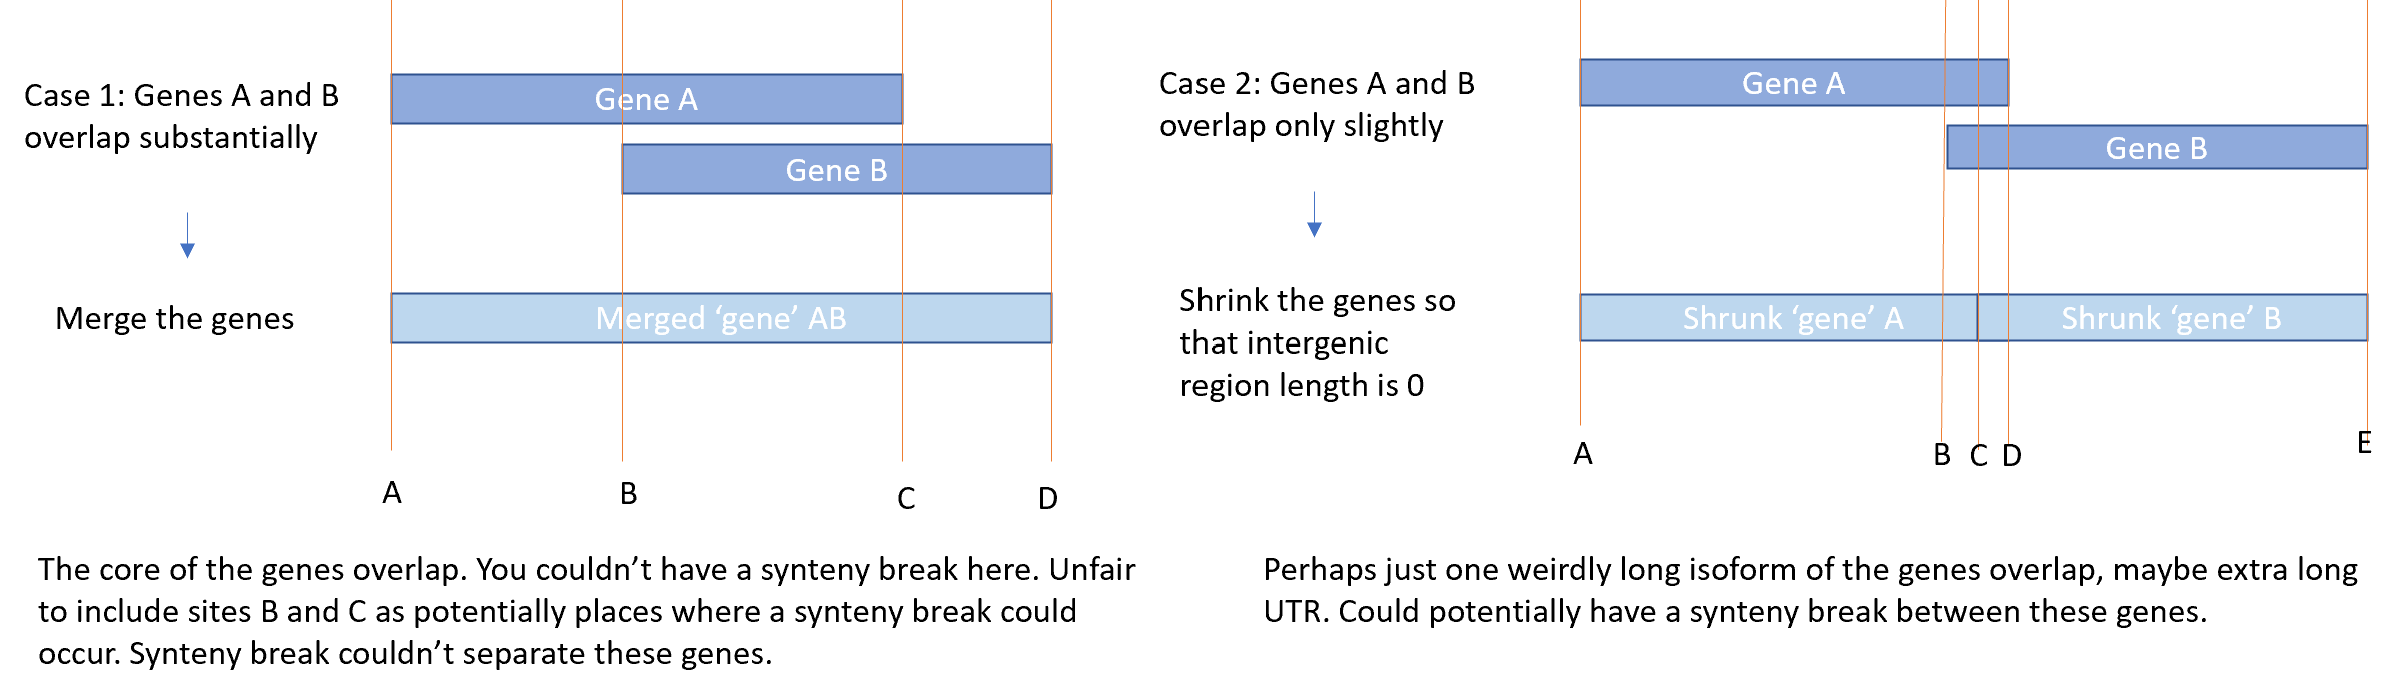

In [1]:
stages=['ee','l3','stage_inv']
cutoffs=[10,51,99]
sets=['set2', 'set4', 'set5', 'set6', 'set7']
domain_types=['all','active','regulated']
operon_options=['no','with']
worms=['briggsae', 'inopinata']

In [2]:
import pandas as pd
import numpy as np
import pickle
import scipy
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [4]:
# hopefully this should make the script work wherever the 'to_transfer' folder is
root_path= !pwd
root_path=root_path[0]

In [5]:
genes_files={}

genes_files['all_e_genes_path']=root_path+'/genesets/elegans_one_of_each_gene.bed'

for worm in worms:
    genes_files[worm]={}
    genes_files[worm]['e_orths_no_ops_path']=root_path+'/genesets/elegans_for_'+worm+'_orths_no_ops.bed'
    genes_files[worm]['b_orths_no_ops_path']=root_path+'/genesets/'+worm+'_orths_no_ops.bed'
    genes_files[worm]['e_orths_with_ops_path']=root_path+'/genesets/elegans_for_'+worm+'_orths_with_ops.bed'
    genes_files[worm]['b_orths_with_ops_path']=root_path+'/genesets/'+worm+'_orths_with_ops.bed'

In [6]:
# ortholog files that you'll need

orths_evals_paths={}
for worm in worms:
    orths_evals_paths[worm]={}
    for is_ops in operon_options:
        orths_evals_paths[worm][is_ops]=root_path+'/ortholog_blast_scores/'+worm+'_query_121_ortholog_rbhs_'+is_ops+'_ops'

In [7]:
bed_12_columns=['chrom','chromStart','chromEnd','name','score','strand','thickStart','thickEnd','itemRgb',
        'blockCount', 'blockSizes', 'blockStart']
chrom_cols=['chrom','chromStart','chromEnd']

In [9]:
def read_nice_intersect_file(path): # made from 2 bed4 files
    names=['gene_chrom','gene_chromStart','gene_chromEnd','gene_name',
           'domain_chrom','domain_chromStart','domain_chromEnd','domain_name']
    return pd.read_csv(path, sep='\t',names=names)

In [10]:
def read_intersect_file(intersect_file): # made from a bed12 gene file and a bed4 domain file
    output=pd.read_csv(intersect_file, sep='\t',header=None)
    output=output.iloc[:,[0,1,2,3,12,13,14,15]]
    output.columns=['gene_chrom','gene_chromStart','gene_chromEnd','gene_name',
                   'domain_chrom','domain_chromStart','domain_chromEnd','domain_name']
    return(output)

In [11]:
pd.read_csv(genes_files['all_e_genes_path'], sep='\t', names=bed_12_columns)

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStart
0,I,4114,10606,WBGene00022277,0,-,4220,10148,0,6,"244,102,291,120,136,77,","0,1080,1922,5612,5980,6415,"
1,I,11494,16837,WBGene00022276,0,+,11640,16585,0,4,"67,72,210,365,","0,123,3456,4978,"
2,I,17482,26781,WBGene00022278,0,-,17910,26778,0,12,"476,110,227,208,117,127,195,162,200,154,92,49,","0,523,1532,2788,3365,3530,7168,7446,7790,8888,..."
3,I,27588,33150,WBGene00022279,0,-,28279,32482,0,6,"817,268,656,304,131,114,","0,1511,2180,4180,4823,5448,"
4,I,43732,44677,WBGene00022275,0,+,43732,44677,0,5,"229,205,44,97,157,","0,297,548,639,788,"
...,...,...,...,...,...,...,...,...,...,...,...,...
20035,X,17671021,17680793,WBGene00020732,0,+,17679538,17680396,0,14,"138,86,90,150,469,304,258,459,222,286,72,418,1...","0,184,2369,3096,3337,3924,4343,4742,5249,5751,..."
20036,X,17680820,17684811,WBGene00044772,0,-,17680910,17682294,0,3,"205,95,56,","0,1379,3935,"
20037,X,17695231,17701744,WBGene00017625,0,+,17696474,17701424,0,7,"88,250,236,221,324,132,491,","0,1241,2747,3028,3474,4465,6022,"
20038,X,17710285,17711698,WBGene00019189,0,-,17710485,17711674,0,5,"416,154,206,105,102,","0,464,777,1095,1311,"


In [518]:
no_ops=pd.read_csv(genes_files['briggsae']['e_orths_no_ops_path'], sep='\t', names=bed_12_columns)
with_ops=pd.read_csv(genes_files['briggsae']['e_orths_with_ops_path'], sep='\t', names=bed_12_columns)

len(set(no_ops['name'])-set(with_ops['name']))

0

# Convert genes files

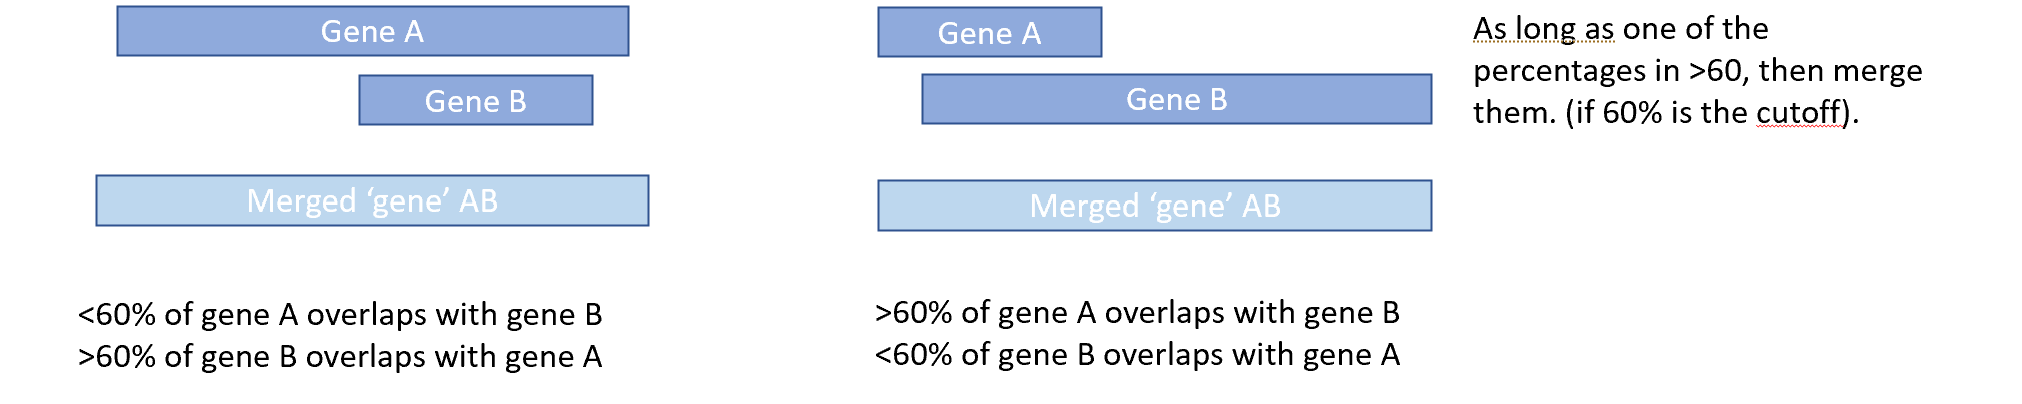

In [411]:
def max_percentage_overlap(df, gene1_index, gene2_index):
    # gene1 starts first
    # gene2 starts before the end of gene1
    
    gene1_start=df['chromStart'][gene1_index]
    gene1_end=df['chromEnd'][gene1_index]
    gene2_start=df['chromStart'][gene2_index]
    gene2_end=df['chromEnd'][gene2_index]
    
    gene1_length=gene1_end-gene1_start
    gene2_length=gene2_end-gene2_start
    
    overlap_length=gene1_end-gene2_start
    
    percent_gene2_in_gene1=100*(overlap_length/gene2_length)
    percent_gene1_in_gene2=100*(overlap_length/gene1_length)
    # both of these could be greater than 100% if one gene is entirely within the other
    # doesn't make sense, but it's fine

    return max(percent_gene2_in_gene1, percent_gene1_in_gene2)

In [522]:
test=pd.DataFrame({'a':[1,2,4,5], 'b':[6,7,8,8]})

In [523]:
test

,a,b
0,1,6
1,2,7
2,4,8
3,5,8


In [525]:
test=test.drop(2, axis=0)

In [526]:
test

,a,b
0,1,6
1,2,7
3,5,8


In [527]:
def df_with_these_genes_merged(old_df, gene1_index, gene2_index):
    
    # make merged gene12
    # replace gene1 row with this
    # remove gene2 row
    
    merged_gene_chrom=old_df['chrom'][gene1_index]
    merged_gene_start=min(old_df['chromStart'][gene1_index], old_df['chromStart'][gene2_index])
    merged_gene_end=max(old_df['chromEnd'][gene1_index], old_df['chromEnd'][gene2_index])
    merged_gene_name=old_df['name'][gene1_index]+'_merged_'+old_df['name'][gene2_index]
    
    new_row=[merged_gene_chrom, merged_gene_start, merged_gene_end, merged_gene_name]
    
    old_df.loc[gene1_index, :]=new_row
    old_df=old_df.drop(gene2_index, axis=0).copy().reset_index(drop=True)
    new_df=old_df.copy()
    
    return new_df

In [528]:
def df_with_these_genes_shrunk(old_df, gene1_index, gene2_index):
    
    #find midpoint between end of gene1 and start of gene2
    # move end of gene1 to there and strat of gene2 to there
    
    gene1_end=old_df['chromEnd'][gene1_index]
    gene2_start=old_df['chromStart'][gene2_index]
    
    midpoint=(gene1_end+gene2_start)/2
    
    gene1_name=old_df['name'][gene1_index]
    gene2_name=old_df['name'][gene2_index]
    
    new_gene1_row=[old_df['chrom'][gene1_index], old_df['chromStart'][gene1_index], midpoint, gene1_name]
    new_gene2_row=[old_df['chrom'][gene2_index], midpoint, old_df['chromEnd'][gene2_index], gene2_name]
        
    old_df.loc[gene1_index, :]=new_gene1_row
    old_df.loc[gene2_index, :]=new_gene2_row
    
    new_df=old_df.copy()

    return new_df

I need to deal with eveything sequentially.
Just look at the gene right below in the dataframe. Decide what to do. REMAKE the dataframe. Move on to the next index.

In [414]:
def deal_with_overlaps ( input_file , threshold ):

    overlaps=[]
    chrom_dfs_dict={}
    chroms=['I','II','III','IV','V','X']
    
    for chrom in chroms:
        chrom_df=input_file[input_file['chrom']==chrom].copy().reset_index(drop=True)
        chrom_df=chrom_df.sort_values('chromStart', ascending=True).copy().reset_index(drop=True)

        index=0

        while index<(len(chrom_df)-1):

            this_end=chrom_df['chromEnd'][index]
            next_start=chrom_df['chromStart'][index+1]

            if this_end<=next_start: # the genes are not overlapping
                index+=1

            if this_end>next_start: # the genes are overlapping

                overlap=max_percentage_overlap(chrom_df, index, index+1) # they are overlapping by this %
                overlaps.append(overlap)

                if overlap>=threshold: # want to merge genes. synteny break could not occur between.
                    chrom_df=df_with_these_genes_merged(chrom_df, index, index+1)
                    # remake chrom_df. Rewrite gene1 as merged gene 1/2, and remove gene2.
                    # next index will not be that of gene 2.

                if overlap<threshold: # likely due to long isoforms. Synteny break could occur. Shrink the genes.
                    chrom_df=df_with_these_genes_shrunk(chrom_df, index, index+1)
                    # remake chrom_df. Now has only the shrunk genes

                index+=1

        chrom_df['chromStart']=chrom_df['chromStart'].astype(int)
        chrom_df['chromEnd']=chrom_df['chromEnd'].astype(int)
        chrom_dfs_dict[chrom]=chrom_df

    final_df=pd.concat([chrom_dfs_dict[chrom] for chrom in chroms])
    
    return ( final_df , overlaps )

In [415]:
def get_overlap_types ( overlaps ):
    
    out_dict={}
    out_dict['all']=len(overlaps)
    out_dict['fully_contained']=len([i for i in overlaps if i>=100])
    out_dict['mostly_contained']=len([i for i in overlaps if 50<=i<100])
    out_dict['quite_overlapped']=len([i for i in overlaps if 10<=i<50])
    out_dict['slightly_overlapped']=len([i for i in overlaps if i <10])
    
    return out_dict

In [529]:
no_overlaps_dfs={}
overlaps_dict={}

for worm in worms:
    no_overlaps_dfs[worm]={}
    overlaps_dict[worm]={}
    
    for file_type in ['e_orths_no_ops', 'b_orths_no_ops', 'e_orths_with_ops', 'b_orths_with_ops']:
        file=pd.read_csv(genes_files[worm][file_type+'_path'], sep='\t', names=bed_12_columns)
        file=file[['chrom','chromStart','chromEnd','name']]

        output = deal_with_overlaps ( file , 50 )
        
        no_overlaps_dfs[worm][file_type]=output[0]
        overlaps_dict[worm][file_type]=output[1]

In [530]:
no_ops=pd.read_csv(genes_files['briggsae']['e_orths_no_ops_path'], sep='\t', names=bed_12_columns)
with_ops=pd.read_csv(genes_files['briggsae']['e_orths_no_ops_path'], sep='\t', names=bed_12_columns)

len(set(no_ops['name'])-set(with_ops['name']))

0

In [532]:
len(set(no_overlaps_dfs['briggsae']['e_orths_with_ops']['name'])-set(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name']))

2857

In [531]:
len(set(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name'])-set(no_overlaps_dfs['briggsae']['e_orths_with_ops']['name']))

119

In [536]:
for i in list(set(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name'])):
    if i not in set(with_ops['name']): print(i)

WBGene00011735_merged_WBGene00011736
WBGene00008999_merged_WBGene00009000
WBGene00010284_merged_WBGene00010285
WBGene00016816_merged_WBGene00016817
WBGene00304992_merged_WBGene00009408
WBGene00019429_merged_WBGene00019434
WBGene00000492_merged_WBGene00010327
WBGene00006618_merged_WBGene00001960
WBGene00003892_merged_WBGene00194855
WBGene00000846_merged_WBGene00194726
WBGene00012868_merged_WBGene00012635
WBGene00021244_merged_WBGene00021249
WBGene00004969_merged_WBGene00001773
WBGene00006606_merged_WBGene00010793
WBGene00012341_merged_WBGene00000697
WBGene00011335_merged_WBGene00011336
WBGene00007670_merged_WBGene00007669
WBGene00017864_merged_WBGene00000992
WBGene00017733_merged_WBGene00017738
WBGene00004946_merged_WBGene00022125
WBGene00011344_merged_WBGene00011345
WBGene00001555_merged_WBGene00011434
WBGene00006479_merged_WBGene00015264
WBGene00022415_merged_WBGene00022412
WBGene00015704_merged_WBGene00020656
WBGene00010542_merged_WBGene00044903
WBGene00001132_merged_WBGene00011708
W

WBGene00012776_merged_WBGene00012777
WBGene00006353_merged_WBGene00002280
WBGene00019074_merged_WBGene00019081
WBGene00002078_merged_WBGene00022813
WBGene00017071_merged_WBGene00017073
WBGene00009178_merged_WBGene00002026
WBGene00013189_merged_WBGene00013190
WBGene00003934_merged_WBGene00018791
WBGene00001553_merged_WBGene00194785
WBGene00016330_merged_WBGene00016327
WBGene00013983_merged_WBGene00013989
WBGene00001018_merged_WBGene00016192
WBGene00016636_merged_WBGene00016639
WBGene00013311_merged_WBGene00013335
WBGene00012107_merged_WBGene00010768
WBGene00012259_merged_WBGene00012260
WBGene00016333_merged_WBGene00016331
WBGene00006620_merged_WBGene00015572
WBGene00021553_merged_WBGene00021552


In [534]:
set(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name'])

{'WBGene00016983',
 'WBGene00005065',
 'WBGene00022671',
 'WBGene00005128',
 'WBGene00009366',
 'WBGene00019407',
 'WBGene00017560',
 'WBGene00001746',
 'WBGene00015864',
 'WBGene00011735_merged_WBGene00011736',
 'WBGene00044437',
 'WBGene00004013',
 'WBGene00009459',
 'WBGene00001715',
 'WBGene00000513',
 'WBGene00001468',
 'WBGene00022643',
 'WBGene00001148',
 'WBGene00017811',
 'WBGene00021919',
 'WBGene00016790',
 'WBGene00008999_merged_WBGene00009000',
 'WBGene00010832',
 'WBGene00017766',
 'WBGene00010925',
 'WBGene00011957',
 'WBGene00011182',
 'WBGene00008599',
 'WBGene00044385',
 'WBGene00013645',
 'WBGene00022539',
 'WBGene00006874',
 'WBGene00018854',
 'WBGene00000004',
 'WBGene00001538',
 'WBGene00004370',
 'WBGene00012854',
 'WBGene00014255',
 'WBGene00011383',
 'WBGene00013398',
 'WBGene00011038',
 'WBGene00006986',
 'WBGene00012068',
 'WBGene00014089',
 'WBGene00008304',
 'WBGene00007357',
 'WBGene00009482',
 'WBGene00002915',
 'WBGene00206513',
 'WBGene00011059',
 'WBGe

In [537]:
for i in list(set(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name'])):
    if i not in set(no_overlaps_dfs['briggsae']['e_orths_with_ops']['name']): print(i)

WBGene00011038
WBGene00023489
WBGene00206502
WBGene00012851
WBGene00022160
WBGene00009205
WBGene00011551
WBGene00022435
WBGene00004045
WBGene00003926
WBGene00021639
WBGene00044634
WBGene00018999
WBGene00016960
WBGene00016699
WBGene00016974
WBGene00000296
WBGene00045250
WBGene00009455
WBGene00013448
WBGene00013202
WBGene00010035
WBGene00012830
WBGene00022030
WBGene00019712
WBGene00008644
WBGene00014224
WBGene00016410
WBGene00003564
WBGene00007022
WBGene00008760
WBGene00011307
WBGene00021834
WBGene00023409
WBGene00018155
WBGene00004909
WBGene00014097
WBGene00010719
WBGene00013738
WBGene00014099
WBGene00008232
WBGene00016114
WBGene00018930
WBGene00022282
WBGene00010460
WBGene00021468
WBGene00022093
WBGene00004856
WBGene00006611
WBGene00012318
WBGene00023487
WBGene00017292
WBGene00012659
WBGene00008316
WBGene00013431
WBGene00194928
WBGene00000286
WBGene00011219
WBGene00006062
WBGene00017268
WBGene00018371
WBGene00015455
WBGene00013726
WBGene00015549
WBGene00022053
WBGene00011971
WBGene0000

In [544]:
[i for i in list(set(no_overlaps_dfs['briggsae']['e_orths_with_ops']['name'])) if 'WBGene00013266' in i]

['WBGene00013255_merged_WBGene00013266']

In [516]:
len(set(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name'])-set(no_overlaps_dfs['briggsae']['e_orths_with_ops']['name']))

119

# Discard genes that are not reciprocal best hits from BLAST

In [418]:
ino_to_e['Sp34_10000510']

'WBGene00008153'

In [419]:
e_to_bri={}
for index, row in pd.read_csv(orths_evals_paths['briggsae']['with']).iterrows():
    e_to_bri[row['target']]=row['query']
    
bri_to_e={}
for index, row in pd.read_csv(orths_evals_paths['briggsae']['with']).iterrows():
    bri_to_e[row['query']]=row['target']
    
e_to_ino={}
for index, row in pd.read_csv(orths_evals_paths['inopinata']['with']).iterrows():
    e_to_ino[row['target']]=row['query']
    
ino_to_e={}
for index, row in pd.read_csv(orths_evals_paths['inopinata']['with']).iterrows():
    ino_to_e[row['query']]=row['target']

In [420]:
convert={}

convert['briggsae']={}
convert['briggsae']['e_orths_no_ops']=e_to_bri
convert['briggsae']['e_orths_with_ops']=e_to_bri
convert['briggsae']['b_orths_no_ops']=bri_to_e
convert['briggsae']['b_orths_with_ops']=bri_to_e

convert['inopinata']={}
convert['inopinata']['e_orths_no_ops']=e_to_ino
convert['inopinata']['e_orths_with_ops']=e_to_ino
convert['inopinata']['b_orths_no_ops']=ino_to_e
convert['inopinata']['b_orths_with_ops']=ino_to_e

In [450]:
test=[i for i in list(no_overlaps_dfs['briggsae']['e_orths_no_ops']['name']) if '_merged_' in i]
len(test)

242

In [448]:
with_orths={}

for worm in worms:
    with_orths[worm]={}
    
    for file_type in ['e_orths_no_ops', 'b_orths_no_ops', 'e_orths_with_ops','b_orths_with_ops']:
        
        no_overlaps_df=no_overlaps_dfs[worm][file_type]
        new_col=[]
        
        for gene in no_overlaps_df['name']:
            
            rbhs=list(convert[worm][file_type].keys())
            
            if '_merged_' in gene:
                pt1=gene.split('_merged_')[0]
                pt2=gene.split('_merged_')[1]
                if pt1 in rbhs and pt2 in rbhs:
                    new_col.append(convert[worm][file_type][pt1]+'_merged_'+convert[worm][file_type][pt2])
                else: new_col.append('bad')
                
            elif gene in rbhs:
                new_col.append(convert[worm][file_type][gene])
            
            else: new_col.append('bad')
        
        no_overlaps_df['ortholog']=new_col
        no_overlaps_df=no_overlaps_df[no_overlaps_df['ortholog']!='bad']
        with_orths[worm][file_type]=no_overlaps_df

In [451]:
test=[i for i in list(no_overlaps_dfs['briggsae']['e_orths_no_ops']['ortholog']) if '_merged_' in i]
len(test)

230

In [514]:
set(with_orths['briggsae']['e_orths_no_ops']['name'])-set(with_orths['briggsae']['e_orths_with_ops']['name'])

{'WBGene00000286',
 'WBGene00000296',
 'WBGene00000625',
 'WBGene00000650',
 'WBGene00001061',
 'WBGene00001145',
 'WBGene00003112',
 'WBGene00003132',
 'WBGene00003564',
 'WBGene00003926',
 'WBGene00004045',
 'WBGene00004778',
 'WBGene00004856',
 'WBGene00004909',
 'WBGene00006062',
 'WBGene00006509',
 'WBGene00006611',
 'WBGene00006617',
 'WBGene00007022',
 'WBGene00007203',
 'WBGene00007969',
 'WBGene00008232',
 'WBGene00008316',
 'WBGene00008502',
 'WBGene00008644',
 'WBGene00008743',
 'WBGene00008760',
 'WBGene00009082',
 'WBGene00009205',
 'WBGene00009455',
 'WBGene00009549',
 'WBGene00010035',
 'WBGene00010460',
 'WBGene00010499',
 'WBGene00010719',
 'WBGene00011038',
 'WBGene00011219',
 'WBGene00011279',
 'WBGene00011307',
 'WBGene00011337',
 'WBGene00011501',
 'WBGene00011551',
 'WBGene00011891',
 'WBGene00011913',
 'WBGene00011971',
 'WBGene00012194',
 'WBGene00012318',
 'WBGene00012391',
 'WBGene00012530',
 'WBGene00012659',
 'WBGene00012830',
 'WBGene00012885',
 'WBGene0001

In [513]:
with_orths['briggsae']['e_orths_with_ops']

,chrom,chromStart,chromEnd,name,ortholog
0,I,4114,10606,WBGene00022277,WBGene00026679
1,I,11494,16837,WBGene00022276,WBGene00026678
2,I,27588,33150,WBGene00022279,WBGene00026677
3,I,47460,49860,WBGene00044345,WBGene00026676
4,I,49920,54426,WBGene00021677,WBGene00026675
...,...,...,...,...,...
1841,X,17650139,17651606,WBGene00044771,WBGene00025055
1842,X,17662444,17665357,WBGene00003744,WBGene00025056
1843,X,17671021,17680793,WBGene00020732,WBGene00025057
1844,X,17680820,17684811,WBGene00044772,WBGene00025059


# Discard genes whose orthologs are merged in one species but not the other

In [452]:
reciprocal_dfs={}

for worm in worms:
    reciprocal_dfs[worm]={}
    
    for is_ops in ['no','with']:
    
        e_df=with_orths[worm]['e_orths_'+is_ops+'_ops']
        b_df=with_orths[worm]['b_orths_'+is_ops+'_ops']

        b_gene_names=set(b_df['name'])
        e_gene_names=set(e_df['name'])

        good_e_ixs=[]
        for ix, name in enumerate(list(e_df['ortholog'])):
            if name in b_gene_names:
                good_e_ixs.append(ix)

        good_b_ixs=[]
        for ix, name in enumerate(list(b_df['ortholog'])):
            if name in e_gene_names:
                good_b_ixs.append(ix)

        reciprocal_dfs[worm]['e_orths_'+is_ops+'_ops']=e_df.iloc[good_e_ixs, :].copy().reset_index(drop=True)
        reciprocal_dfs[worm]['b_orths_'+is_ops+'_ops']=b_df.iloc[good_b_ixs, :].copy().reset_index(drop=True)

# Reorder b worm dataframes

In [453]:
def reorder_b_worm_df ( b_worm_df, e_worm_df ):
    
    ixs_in_order=[]

    for index, row in e_worm_df.iterrows():
        orth=row['ortholog']
        in_b_worm=b_worm_df[b_worm_df['name']==orth].index.to_list()[0]
        ixs_in_order.append(in_b_worm)
        
    out=b_worm_df.iloc[ixs_in_order, :].copy().reset_index(drop=True)
    return out

In [457]:
final_dfs={}

for worm in worms:
    final_dfs[worm]={}
    for is_ops in ['no','with']:
        
        e_worm_df=reciprocal_dfs[worm]['e_orths_'+is_ops+'_ops']
        b_worm_df=reciprocal_dfs[worm]['b_orths_'+is_ops+'_ops']
        
        print(len(e_worm_df))
        print(len(b_worm_df))
        
        new_b_worm_df=reorder_b_worm_df ( b_worm_df , e_worm_df )
        
        final_dfs[worm]['e_orths_'+is_ops+'_ops']=e_worm_df.drop('ortholog', axis=1)
        final_dfs[worm]['b_orths_'+is_ops+'_ops']=new_b_worm_df.drop('ortholog', axis=1)

7944
7944
10389
10389
7588
7588
10159
10159


# Make new orth rbh files

In [476]:
orths_evals_dfs={}

for worm in worms:
    orths_evals_dfs[worm]={}
    for is_ops in ['no','with']:
        
        e_df=final_dfs[worm]['e_orths_'+is_ops+'_ops']
        b_df=final_dfs[worm]['b_orths_'+is_ops+'_ops']
        evals_df=pd.read_csv(orths_evals_paths[worm][is_ops])
        
        queries=[]
        targets=[]
        evalues=[]
        
        for index in range(len(e_df)):
            
            queries.append(b_df['name'][index])
            targets.append(e_df['name'][index])
            
            to_use=b_df['name'][index].split('_merged_')[0]
            row_in_evals_df=evals_df[evals_df['query']==to_use].reset_index(drop=True)
            evalue=row_in_evals_df['e_value'][0]
            
            evalues.append(evalue)
            
        out_df=pd.DataFrame({'query':queries, 'target':targets, 'e_value':evalues})
        orths_evals_dfs[worm][is_ops]=out_df

# Save files

In [492]:
for worm in worms:
    for is_ops in ['with','no']:
        
        path=root_path+'/new_ortholog_blast_scores/'+worm+'_query_121_ortholog_rbhs_'+is_ops+'_ops'
        orths_evals_dfs[worm][is_ops].to_csv(path, index=None)
        print(len(orths_evals_dfs[worm][is_ops]))

10389
7944
10159
7588


In [493]:
for worm in worms:
    for file_type in ['e_orths', 'b_orths']:
        for is_ops in ['with','no']:
        
            path=root_path+'/new_genesets/'+worm+'_'+file_type+'_'+is_ops+'_ops.bed'
            final_dfs[worm][file_type+'_'+is_ops+'_ops'].to_csv(path, sep='\t', index=None, header=None)
            print(len(final_dfs[worm][file_type+'_'+is_ops+'_ops']))

10389
7944
10389
7944
10159
7588
10159
7588


In [496]:
no_ops=final_dfs['briggsae']['e_orths_no_ops']
with_ops=final_dfs['briggsae']['e_orths_with_ops']

In [501]:
(set(no_ops['name'])-set(with_ops['name']))

{'WBGene00000286',
 'WBGene00000296',
 'WBGene00000475',
 'WBGene00000497',
 'WBGene00000625',
 'WBGene00000650',
 'WBGene00000681',
 'WBGene00001061',
 'WBGene00001145',
 'WBGene00001544',
 'WBGene00001637',
 'WBGene00001669',
 'WBGene00001757',
 'WBGene00001814',
 'WBGene00002204',
 'WBGene00003057',
 'WBGene00003097',
 'WBGene00003112',
 'WBGene00003172',
 'WBGene00003242_merged_WBGene00016499',
 'WBGene00003564',
 'WBGene00003732',
 'WBGene00003918',
 'WBGene00003926',
 'WBGene00004045',
 'WBGene00004778',
 'WBGene00004793',
 'WBGene00004856',
 'WBGene00004909',
 'WBGene00004953',
 'WBGene00006062',
 'WBGene00006509',
 'WBGene00006611',
 'WBGene00006617',
 'WBGene00006776',
 'WBGene00006922',
 'WBGene00007022',
 'WBGene00007099',
 'WBGene00007203',
 'WBGene00007916',
 'WBGene00007969',
 'WBGene00007976',
 'WBGene00008232',
 'WBGene00008316',
 'WBGene00008502',
 'WBGene00008640',
 'WBGene00008644',
 'WBGene00008743',
 'WBGene00008760',
 'WBGene00008777',
 'WBGene00009082',
 'WBGene0

# Edit all genes df

In [585]:
all_genes=pd.read_csv(genes_files['all_e_genes_path'], sep='\t', names=bed_12_columns)

I just need to deal with the genes that are merged in the orths no ops files

This means that I'll need different 'all genes' files for all my different options. 

- Go through the final dfs file
- when you get to merged genes, find the two merged genes in the all genes file
- rewrite one of these as the merged gene, and remove the other one

In [600]:
all_genes_dfs={}

for worm in worms:
    all_genes_dfs[worm]={}
    for file_type in ['e_orths_no_ops', 'e_orths_with_ops']:
        
        orths_no_overlaps=final_dfs[worm][file_type]
        all_genes_cur=all_genes.copy()
        
        for index, row in orths_no_overlaps.iterrows():
            
            start=row['chromStart']
            end=row['chromEnd']
            name=row['name']

            if '_merged_' in name:
                
                pt1=row['name'].split('_merged_')[0]
                pt2=row['name'].split('_merged_')[1]

                all_genes_row_pt1=all_genes_cur[all_genes_cur['name']==pt1].index.to_list()[0]
                all_genes_row_pt2=all_genes_cur[all_genes_cur['name']==pt2].index.to_list()[0]

                all_genes_cur.loc[all_genes_row_pt1,'chromStart'] = start
                all_genes_cur.loc[all_genes_row_pt1,'chromEnd'] = end
                all_genes_cur.loc[all_genes_row_pt1,'name'] = name
                
                all_genes_cur=all_genes_cur.drop(all_genes_row_pt2, axis=0)
                
            else: # resize as was done in orths_no_ops file
                
                all_genes_row=all_genes_cur[all_genes_cur['name']==name].index.to_list()[0]
                all_genes_cur.loc[all_genes_row,'chromStart'] = start
                all_genes_cur.loc[all_genes_row,'chromEnd'] = end
                
        all_genes_dfs[worm][file_type]=all_genes_cur
        all_genes_cur.to_csv(root_path+'/new_genesets/elegans_all_genes_with_merged_for_'+worm+'_'+file_type
                            , sep='\t', header=None, index=None)

In [601]:
all_genes_dfs['briggsae']['e_orths_no_ops']

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStart
0,I,4114,10606,WBGene00022277,0,-,4220,10148,0,6,"244,102,291,120,136,77,","0,1080,1922,5612,5980,6415,"
1,I,11494,16837,WBGene00022276,0,+,11640,16585,0,4,"67,72,210,365,","0,123,3456,4978,"
2,I,17482,26781,WBGene00022278,0,-,17910,26778,0,12,"476,110,227,208,117,127,195,162,200,154,92,49,","0,523,1532,2788,3365,3530,7168,7446,7790,8888,..."
3,I,27588,33150,WBGene00022279,0,-,28279,32482,0,6,"817,268,656,304,131,114,","0,1511,2180,4180,4823,5448,"
4,I,43732,44677,WBGene00022275,0,+,43732,44677,0,5,"229,205,44,97,157,","0,297,548,639,788,"
...,...,...,...,...,...,...,...,...,...,...,...,...
20035,X,17671021,17680793,WBGene00020732,0,+,17679538,17680396,0,14,"138,86,90,150,469,304,258,459,222,286,72,418,1...","0,184,2369,3096,3337,3924,4343,4742,5249,5751,..."
20036,X,17680820,17684811,WBGene00044772,0,-,17680910,17682294,0,3,"205,95,56,","0,1379,3935,"
20037,X,17695231,17701744,WBGene00017625,0,+,17696474,17701424,0,7,"88,250,236,221,324,132,491,","0,1241,2747,3028,3474,4465,6022,"
20038,X,17710285,17711698,WBGene00019189,0,-,17710485,17711674,0,5,"416,154,206,105,102,","0,464,777,1095,1311,"


In [589]:
all_genes_dfs['briggsae']['e_orths_no_ops']

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStart
0,I,4114,10606,WBGene00022277,0,-,4220,10148,0,6,"244,102,291,120,136,77,","0,1080,1922,5612,5980,6415,"
1,I,11494,16837,WBGene00022276,0,+,11640,16585,0,4,"67,72,210,365,","0,123,3456,4978,"
2,I,17482,26781,WBGene00022278,0,-,17910,26778,0,12,"476,110,227,208,117,127,195,162,200,154,92,49,","0,523,1532,2788,3365,3530,7168,7446,7790,8888,..."
3,I,27588,33150,WBGene00022279,0,-,28279,32482,0,6,"817,268,656,304,131,114,","0,1511,2180,4180,4823,5448,"
4,I,43732,44677,WBGene00022275,0,+,43732,44677,0,5,"229,205,44,97,157,","0,297,548,639,788,"
...,...,...,...,...,...,...,...,...,...,...,...,...
20035,X,17671021,17680793,WBGene00020732,0,+,17679538,17680396,0,14,"138,86,90,150,469,304,258,459,222,286,72,418,1...","0,184,2369,3096,3337,3924,4343,4742,5249,5751,..."
20036,X,17680820,17684811,WBGene00044772,0,-,17680910,17682294,0,3,"205,95,56,","0,1379,3935,"
20037,X,17695231,17701744,WBGene00017625,0,+,17696474,17701424,0,7,"88,250,236,221,324,132,491,","0,1241,2747,3028,3474,4465,6022,"
20038,X,17710285,17711698,WBGene00019189,0,-,17710485,17711674,0,5,"416,154,206,105,102,","0,464,777,1095,1311,"
